In [42]:
from fastai import *
from fastai.text import *
bs=128
data_path = Config.data_path()

In [2]:
def get_wiki(path,lang):
    name = f'{lang}wiki'
    if (path/name).exists():
        print(f"{path/name} already exists; not downloading")
        return

    xml_fn = f"{lang}wiki-latest-pages-articles.xml"
    zip_fn = f"{xml_fn}.bz2"

    if not (path/xml_fn).exists():
        print("downloading...")
        download_url(f'https://dumps.wikimedia.org/{name}/latest/{zip_fn}', path/zip_fn)
        print("unzipping...")
        bunzip(path/zip_fn)

    with working_directory(path):
        if not (path/'wikiextractor').exists(): os.system('git clone https://github.com/attardi/wikiextractor.git')
        print("extracting...")
        os.system("python wikiextractor/WikiExtractor.py --processes 4 --no_templates " +
            f"--min_text_length 1800 --filter_disambig_pages --log_file log -b 100G -q {xml_fn}")
    shutil.move(str(path/'text/AA/wiki_00'), str(path/name))
    shutil.rmtree(path/'text')


def split_wiki(path,lang):
    dest = path/'docs'
    name = f'{lang}wiki'
    if dest.exists():
        print(f"{dest} already exists; not splitting")
        return dest

    dest.mkdir(exist_ok=True, parents=True)
    title_re = re.compile(rf'<doc id="\d+" url="https://{lang}.wikipedia.org/wiki\?curid=\d+" title="([^"]+)">')
    lines = (path/name).open()
    f=None

    for i,l in enumerate(lines):
        if i%100000 == 0: print(i)
        if l.startswith('<doc id="'):
            title = title_re.findall(l)[0].replace('/','_')
            if len(title)>150: continue
            if f: f.close()
            f = (dest/f'{title}.txt').open('w')
        else: f.write(l)
    f.close()
    return dest

In [2]:
lang = 'hu'
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

In [4]:
get_wiki(path,lang)
dest = split_wiki(path,lang)
dest.ls()[:5]

/home/jupyter/.fastai/data/huwiki/huwiki already exists; not downloading
/home/jupyter/.fastai/data/huwiki/docs already exists; not splitting


[PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Gyorsvonati pótjegy.txt'),
 PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Orlande de Lassus.txt'),
 PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Ringelheimi Matilda.txt'),
 PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Antioxidánsok kapacitása.txt'),
 PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Bosworthi csata.txt')]

In [35]:
dest = data_path/"huwiki/docs"
dest.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Gyorsvonati pótjegy.txt'),
 PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Orlande de Lassus.txt'),
 PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Ringelheimi Matilda.txt'),
 PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Antioxidánsok kapacitása.txt'),
 PosixPath('/home/jupyter/.fastai/data/huwiki/docs/Bosworthi csata.txt')]

In [36]:
data = (TextList.from_folder(dest)
                .split_by_rand_pct(0.1, seed=42)
                .label_for_lm()
                .databunch(bs=bs, num_workers=1))

In [37]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [73]:
doc(language_model_learner)

In [376]:
lr=1e-4

learn.unfreeze()
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
learn.save("ulmfit_v2_bme")

epoch,train_loss,valid_loss,accuracy,time
0,3.574805,2.428606,0.557143,1:20:15


In [373]:
learn.lr_find();

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [10]:
#mdl_path = path/'models'
#mdl_path.mkdir(exist_ok=True)
#learn.save(mdl_path/lm_fns[0], with_opt=False)
#learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

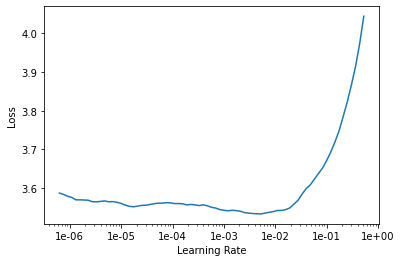

In [375]:
learn.recorder.plot(skip_end=15)

In [38]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.load(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.load(mdl_path/(lm_fns[1] + '.pkl'))

In [91]:
TEXT = "A világ nem más"
N_WORDS = 80
N_SENTENCES = 1

In [93]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

A világ nem más , mint Amerika . 
 
  a város egy , a Föld felszínén élő róka , a róka és a róka . a Róka - hegyen Henry Jackson rendelkezik az első ember , aki egy Mexikó - ellenes első katonai küldetés során a Föld egyik legnagyobb testű részén élt . a legtöbb ember a Földön él , de az Egyesült Államokban egyes fajok a múlt század közepén ( a mai


In [65]:
learn.freeze()

In [22]:
learn.load(mdl_path/lm_fns[0], with_opt=False)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (68 items)
x: LMTextList
xxbos xxmaj jules xxmaj verne 
 
  a xxup világ xxup ura 
 
  xxup első xxup fejezet 
 
  xxmaj mi történik a xxmaj kék - hegységben ? 
  xxup második xxup fejezet 
 
  xxmaj morgantonban 
  xxup harmadik xxup fejezet 
 
  a xxmaj nagy xxmaj sasfészek 
  xxup negyedik xxup fejezet 
 
  xxmaj az xxmaj automobil xxmaj klub versenye 
  xxup ötödik xxup fejezet 
 
  xxmaj új - xxmaj anglia partjai körül 
  xxup hatodik xxup fejezet 
 
  xxmaj az első levél 
  xxup hetedik xxup fejezet 
 
  xxmaj harmadszorra 
  xxup nyolcadik xxup fejezet 
 
  xxmaj mindenáron 
  xxup kilencedik xxup fejezet 
 
  a második levél 
  xxup tizedik xxup fejezet 
 
  xxmaj törvényen kívül 
  xxup tizenegyedik xxup fejezet 
 
  xxmaj xxunk 
  xxup tizenkettedik xxup fejezet 
 
  a xxmaj black xxmaj rock - öböl 
  xxup tizenharmadik xxup fejezet 
 
  a xxmaj rém fedélzetén 
  xxup tizennegyedik xxup fejezet 
 
  a xxmaj niagara 
  xx